**Choropleth Map of World Power Consumption in 2014**

In [1]:
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
# Also:
import chart_studio.plotly as py

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read csv file
df = pd.read_csv('2014_World_Power_Consumption')

In [5]:
df.head()

,Country,Power Consumption KWH,Text
0,China,5.523000e+12,"China 5,523,000,000,000"
1,United States,3.832000e+12,"United 3,832,000,000,000"
2,European,2.771000e+12,"European 2,771,000,000,000"
3,Russia,1.065000e+12,"Russia 1,065,000,000,000"
4,Japan,9.210000e+11,"Japan 921,000,000,000"


Note that countries that compound nouns cannot be distinguished in the *Text* column and consequently, *Plotly* is unable to generate choropleth shades for such countries (such as the United *States*). Let us see how widespread this problem is

In [6]:
df['Text_split[0]'] = df['Text'].map(lambda x : x.split(' ')[0])

In [7]:
df.head()

,Country,Power Consumption KWH,Text,Text_split[0]
0,China,5.523000e+12,"China 5,523,000,000,000",China
1,United States,3.832000e+12,"United 3,832,000,000,000",United
2,European,2.771000e+12,"European 2,771,000,000,000",European
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",Russia
4,Japan,9.210000e+11,"Japan 921,000,000,000",Japan


In [8]:
ambigious = np.setdiff1d(list(df['Text_split[0]']),list(df['Country']),assume_unique=False)
ambigious

array(['United'], dtype='<U13')

In [9]:
df[df['Text_split[0]']=='United']

,Country,Power Consumption KWH,Text,Text_split[0]
1,United States,3.832000e+12,"United 3,832,000,000,000",United
11,United Kingdom,3.191000e+11,"United 319,100,000,000",United
33,United Arab Emirates,9.328000e+10,"United 93,280,000,000",United


In [10]:
def united(col):
    Country = col[0]
    Text_split = col[1]
    
    if Text_split == 'United':
        return Country
    else:
        return Text_split

In [11]:
df['Text_split[0]'] = df[['Country','Text_split[0]']].apply(united,axis=1) 

In [12]:
df.head()

,Country,Power Consumption KWH,Text,Text_split[0]
0,China,5.523000e+12,"China 5,523,000,000,000",China
1,United States,3.832000e+12,"United 3,832,000,000,000",United States
2,European,2.771000e+12,"European 2,771,000,000,000",European
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",Russia
4,Japan,9.210000e+11,"Japan 921,000,000,000",Japan


In [13]:
def text(col):
    First = col[0]
    Second = col[1]
    
    First_split = First.split(' ')
    if First_split[0] != Second:
        First_split[0] = Second
        return ' '.join(First_split)
    else:
        return ' '.join(First_split)

In [14]:
df['Text'] = df[['Text','Text_split[0]']].apply(text,axis=1)

In [15]:
df.head()

,Country,Power Consumption KWH,Text,Text_split[0]
0,China,5.523000e+12,"China 5,523,000,000,000",China
1,United States,3.832000e+12,"United States 3,832,000,000,000",United States
2,European,2.771000e+12,"European 2,771,000,000,000",European
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",Russia
4,Japan,9.210000e+11,"Japan 921,000,000,000",Japan


In [16]:
data = dict(type = 'choropleth',
            locations = df['Text'],
            locationmode = "country names" ,
            marker = dict(line = dict(color = 'rgb(0,0,0)',width=1)),
            colorscale = 'ylorrd',
            z = df['Power Consumption KWH'],
            text = df['Country'],
            colorbar = {'title':'2014 Power Consumption'}
           )
layout = dict(title = '2014 Power Consumption',
             geo = dict(scope='world',showframe=False,
                        projection = {'type':'mercator'})
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

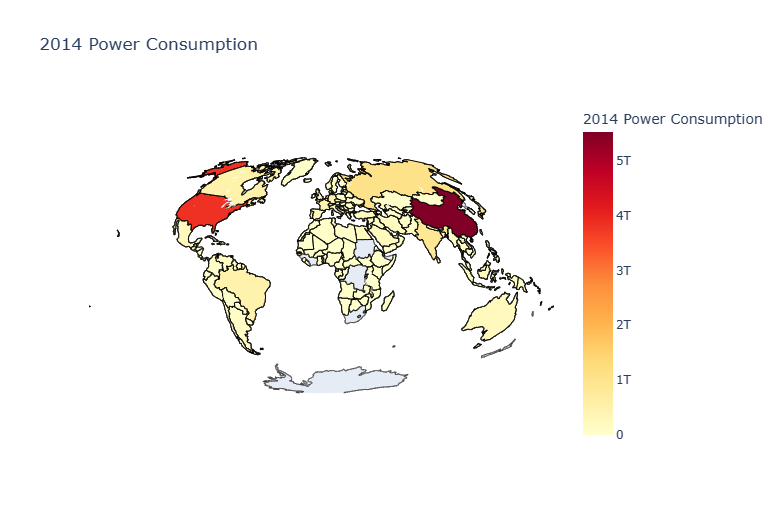

In [17]:
import requests
from bs4 import BeautifulSoup

In [18]:
URL = "http://country.io/names.json"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")

In [19]:
soup

{"BD": "Bangladesh", "BE": "Belgium", "BF": "Burkina Faso", "BG": "Bulgaria", "BA": "Bosnia and Herzegovina", "BB": "Barbados", "WF": "Wallis and Futuna", "BL": "Saint Barthelemy", "BM": "Bermuda", "BN": "Brunei", "BO": "Bolivia", "BH": "Bahrain", "BI": "Burundi", "BJ": "Benin", "BT": "Bhutan", "JM": "Jamaica", "BV": "Bouvet Island", "BW": "Botswana", "WS": "Samoa", "BQ": "Bonaire, Saint Eustatius and Saba ", "BR": "Brazil", "BS": "Bahamas", "JE": "Jersey", "BY": "Belarus", "BZ": "Belize", "RU": "Russia", "RW": "Rwanda", "RS": "Serbia", "TL": "East Timor", "RE": "Reunion", "TM": "Turkmenistan", "TJ": "Tajikistan", "RO": "Romania", "TK": "Tokelau", "GW": "Guinea-Bissau", "GU": "Guam", "GT": "Guatemala", "GS": "South Georgia and the South Sandwich Islands", "GR": "Greece", "GQ": "Equatorial Guinea", "GP": "Guadeloupe", "JP": "Japan", "GY": "Guyana", "GG": "Guernsey", "GF": "French Guiana", "GE": "Georgia", "GD": "Grenada", "GB": "United Kingdom", "GA": "Gabon", "SV": "El Salvador", "GN":

In [20]:
type(soup)

bs4.BeautifulSoup

In [21]:
soup2 = BeautifulSoup(page.text,"lxml")
soup2

<html><body><p>{"BD": "Bangladesh", "BE": "Belgium", "BF": "Burkina Faso", "BG": "Bulgaria", "BA": "Bosnia and Herzegovina", "BB": "Barbados", "WF": "Wallis and Futuna", "BL": "Saint Barthelemy", "BM": "Bermuda", "BN": "Brunei", "BO": "Bolivia", "BH": "Bahrain", "BI": "Burundi", "BJ": "Benin", "BT": "Bhutan", "JM": "Jamaica", "BV": "Bouvet Island", "BW": "Botswana", "WS": "Samoa", "BQ": "Bonaire, Saint Eustatius and Saba ", "BR": "Brazil", "BS": "Bahamas", "JE": "Jersey", "BY": "Belarus", "BZ": "Belize", "RU": "Russia", "RW": "Rwanda", "RS": "Serbia", "TL": "East Timor", "RE": "Reunion", "TM": "Turkmenistan", "TJ": "Tajikistan", "RO": "Romania", "TK": "Tokelau", "GW": "Guinea-Bissau", "GU": "Guam", "GT": "Guatemala", "GS": "South Georgia and the South Sandwich Islands", "GR": "Greece", "GQ": "Equatorial Guinea", "GP": "Guadeloupe", "JP": "Japan", "GY": "Guyana", "GG": "Guernsey", "GF": "French Guiana", "GE": "Georgia", "GD": "Grenada", "GB": "United Kingdom", "GA": "Gabon", "SV": "El S

In [22]:
type(soup.extract())

bs4.BeautifulSoup

In [23]:
j = soup.string.replace('{','')
j = j.replace('}','')
j

'"BD": "Bangladesh", "BE": "Belgium", "BF": "Burkina Faso", "BG": "Bulgaria", "BA": "Bosnia and Herzegovina", "BB": "Barbados", "WF": "Wallis and Futuna", "BL": "Saint Barthelemy", "BM": "Bermuda", "BN": "Brunei", "BO": "Bolivia", "BH": "Bahrain", "BI": "Burundi", "BJ": "Benin", "BT": "Bhutan", "JM": "Jamaica", "BV": "Bouvet Island", "BW": "Botswana", "WS": "Samoa", "BQ": "Bonaire, Saint Eustatius and Saba ", "BR": "Brazil", "BS": "Bahamas", "JE": "Jersey", "BY": "Belarus", "BZ": "Belize", "RU": "Russia", "RW": "Rwanda", "RS": "Serbia", "TL": "East Timor", "RE": "Reunion", "TM": "Turkmenistan", "TJ": "Tajikistan", "RO": "Romania", "TK": "Tokelau", "GW": "Guinea-Bissau", "GU": "Guam", "GT": "Guatemala", "GS": "South Georgia and the South Sandwich Islands", "GR": "Greece", "GQ": "Equatorial Guinea", "GP": "Guadeloupe", "JP": "Japan", "GY": "Guyana", "GG": "Guernsey", "GF": "French Guiana", "GE": "Georgia", "GD": "Grenada", "GB": "United Kingdom", "GA": "Gabon", "SV": "El Salvador", "GN":

In [24]:
j = j.replace('"','')
j = j.replace('"','')
j

'BD: Bangladesh, BE: Belgium, BF: Burkina Faso, BG: Bulgaria, BA: Bosnia and Herzegovina, BB: Barbados, WF: Wallis and Futuna, BL: Saint Barthelemy, BM: Bermuda, BN: Brunei, BO: Bolivia, BH: Bahrain, BI: Burundi, BJ: Benin, BT: Bhutan, JM: Jamaica, BV: Bouvet Island, BW: Botswana, WS: Samoa, BQ: Bonaire, Saint Eustatius and Saba , BR: Brazil, BS: Bahamas, JE: Jersey, BY: Belarus, BZ: Belize, RU: Russia, RW: Rwanda, RS: Serbia, TL: East Timor, RE: Reunion, TM: Turkmenistan, TJ: Tajikistan, RO: Romania, TK: Tokelau, GW: Guinea-Bissau, GU: Guam, GT: Guatemala, GS: South Georgia and the South Sandwich Islands, GR: Greece, GQ: Equatorial Guinea, GP: Guadeloupe, JP: Japan, GY: Guyana, GG: Guernsey, GF: French Guiana, GE: Georgia, GD: Grenada, GB: United Kingdom, GA: Gabon, SV: El Salvador, GN: Guinea, GM: Gambia, GL: Greenland, GI: Gibraltar, GH: Ghana, OM: Oman, TN: Tunisia, JO: Jordan, HR: Croatia, HT: Haiti, HU: Hungary, HK: Hong Kong, HN: Honduras, HM: Heard Island and McDonald Islands, 

In [25]:
k = j.split(',')
k

['BD: Bangladesh',
 ' BE: Belgium',
 ' BF: Burkina Faso',
 ' BG: Bulgaria',
 ' BA: Bosnia and Herzegovina',
 ' BB: Barbados',
 ' WF: Wallis and Futuna',
 ' BL: Saint Barthelemy',
 ' BM: Bermuda',
 ' BN: Brunei',
 ' BO: Bolivia',
 ' BH: Bahrain',
 ' BI: Burundi',
 ' BJ: Benin',
 ' BT: Bhutan',
 ' JM: Jamaica',
 ' BV: Bouvet Island',
 ' BW: Botswana',
 ' WS: Samoa',
 ' BQ: Bonaire',
 ' Saint Eustatius and Saba ',
 ' BR: Brazil',
 ' BS: Bahamas',
 ' JE: Jersey',
 ' BY: Belarus',
 ' BZ: Belize',
 ' RU: Russia',
 ' RW: Rwanda',
 ' RS: Serbia',
 ' TL: East Timor',
 ' RE: Reunion',
 ' TM: Turkmenistan',
 ' TJ: Tajikistan',
 ' RO: Romania',
 ' TK: Tokelau',
 ' GW: Guinea-Bissau',
 ' GU: Guam',
 ' GT: Guatemala',
 ' GS: South Georgia and the South Sandwich Islands',
 ' GR: Greece',
 ' GQ: Equatorial Guinea',
 ' GP: Guadeloupe',
 ' JP: Japan',
 ' GY: Guyana',
 ' GG: Guernsey',
 ' GF: French Guiana',
 ' GE: Georgia',
 ' GD: Grenada',
 ' GB: United Kingdom',
 ' GA: Gabon',
 ' SV: El Salvador',
 ' 

In [26]:
l = []
for i in k:
    l.append(i.split(':'))
l

[['BD', ' Bangladesh'],
 [' BE', ' Belgium'],
 [' BF', ' Burkina Faso'],
 [' BG', ' Bulgaria'],
 [' BA', ' Bosnia and Herzegovina'],
 [' BB', ' Barbados'],
 [' WF', ' Wallis and Futuna'],
 [' BL', ' Saint Barthelemy'],
 [' BM', ' Bermuda'],
 [' BN', ' Brunei'],
 [' BO', ' Bolivia'],
 [' BH', ' Bahrain'],
 [' BI', ' Burundi'],
 [' BJ', ' Benin'],
 [' BT', ' Bhutan'],
 [' JM', ' Jamaica'],
 [' BV', ' Bouvet Island'],
 [' BW', ' Botswana'],
 [' WS', ' Samoa'],
 [' BQ', ' Bonaire'],
 [' Saint Eustatius and Saba '],
 [' BR', ' Brazil'],
 [' BS', ' Bahamas'],
 [' JE', ' Jersey'],
 [' BY', ' Belarus'],
 [' BZ', ' Belize'],
 [' RU', ' Russia'],
 [' RW', ' Rwanda'],
 [' RS', ' Serbia'],
 [' TL', ' East Timor'],
 [' RE', ' Reunion'],
 [' TM', ' Turkmenistan'],
 [' TJ', ' Tajikistan'],
 [' RO', ' Romania'],
 [' TK', ' Tokelau'],
 [' GW', ' Guinea-Bissau'],
 [' GU', ' Guam'],
 [' GT', ' Guatemala'],
 [' GS', ' South Georgia and the South Sandwich Islands'],
 [' GR', ' Greece'],
 [' GQ', ' Equatori

In [27]:
values = []
for i in l:
    if len(i) >= 2:
        values.append(i[1])
    else:
        values.append(i[0])

In [28]:
value_list = []
for i in values:
    value_list.append(i[1:])
value_list

['Bangladesh',
 'Belgium',
 'Burkina Faso',
 'Bulgaria',
 'Bosnia and Herzegovina',
 'Barbados',
 'Wallis and Futuna',
 'Saint Barthelemy',
 'Bermuda',
 'Brunei',
 'Bolivia',
 'Bahrain',
 'Burundi',
 'Benin',
 'Bhutan',
 'Jamaica',
 'Bouvet Island',
 'Botswana',
 'Samoa',
 'Bonaire',
 'Saint Eustatius and Saba ',
 'Brazil',
 'Bahamas',
 'Jersey',
 'Belarus',
 'Belize',
 'Russia',
 'Rwanda',
 'Serbia',
 'East Timor',
 'Reunion',
 'Turkmenistan',
 'Tajikistan',
 'Romania',
 'Tokelau',
 'Guinea-Bissau',
 'Guam',
 'Guatemala',
 'South Georgia and the South Sandwich Islands',
 'Greece',
 'Equatorial Guinea',
 'Guadeloupe',
 'Japan',
 'Guyana',
 'Guernsey',
 'French Guiana',
 'Georgia',
 'Grenada',
 'United Kingdom',
 'Gabon',
 'El Salvador',
 'Guinea',
 'Gambia',
 'Greenland',
 'Gibraltar',
 'Ghana',
 'Oman',
 'Tunisia',
 'Jordan',
 'Croatia',
 'Haiti',
 'Hungary',
 'Hong Kong',
 'Honduras',
 'Heard Island and McDonald Islands',
 'Venezuela',
 'Puerto Rico',
 'Palestinian Territory',
 'Pala

In [29]:
value_list.sort()
value_list

['Afghanistan',
 'Aland Islands',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos Islands',
 'Colombia',
 'Comoros',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eq

In [30]:
len(value_list)

251

In [31]:
ambigious = np.setdiff1d(list(df['Country']),value_list)
ambigious

array(['American', 'Antigua', 'Bahamas,', 'Bosnia', 'British', 'Burkina',
       'Burma', 'Cabo', 'Cayman', 'Central', 'Congo,', 'Cook', 'Costa',
       'Cote', 'Czechia', 'Dominican', 'El', 'Equatorial', 'European',
       'Falkland', 'Faroe', 'French', 'Gambia,', 'Gaza', 'Hong', 'Korea,',
       'Macau', 'Micronesia,', 'New', 'Northern', 'Papua', 'Puerto',
       'Saint', 'Sao', 'Saudi', 'Sierra', 'Solomon', 'South', 'Sri',
       'Timor-Leste', 'Trinidad', 'Turks', 'Virgin', 'West', 'Western'],
      dtype='<U20')

In [32]:
len(ambigious)

45

In [33]:
l = []
for i in ambigious:
    for j in value_list:
        if i in j.split(' '):
            l.append(j)
l       

['American Samoa',
 'Antigua and Barbuda',
 'Bosnia and Herzegovina',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Burkina Faso',
 'Cayman Islands',
 'Central African Republic',
 'Cook Islands',
 'Costa Rica',
 'Dominican Republic',
 'El Salvador',
 'Equatorial Guinea',
 'Falkland Islands',
 'Faroe Islands',
 'French Guiana',
 'French Polynesia',
 'French Southern Territories',
 'Hong Kong',
 'New Caledonia',
 'New Zealand',
 'Papua New Guinea',
 'Northern Mariana Islands',
 'Papua New Guinea',
 'Puerto Rico',
 'Saint Barthelemy',
 'Saint Eustatius and Saba ',
 'Saint Helena',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Martin',
 'Saint Pierre and Miquelon',
 'Saint Vincent and the Grenadines',
 'Sao Tome and Principe',
 'Saudi Arabia',
 'Sierra Leone',
 'Solomon Islands',
 'South Africa',
 'South Georgia and the South Sandwich Islands',
 'South Korea',
 'South Sudan',
 'Sri Lanka',
 'Trinidad and Tobago',
 'Turks and Caicos Islands',
 'British Virgin Islands',

In [34]:
len(l)

47

In [35]:
l.remove('British Indian Ocean Territory')
l.remove('South Georgia and the South Sandwich Islands')
len(l)

45

In [36]:
df[(df['Text_split[0]']== 'French') | (df['Text_split[0]']== 'New') | (df['Text_split[0]']== 'Saint') | (df['Text_split[0]']== 'South')]

,Country,Power Consumption KWH,Text,Text_split[0]
18,South,2.116000e+11,"South 211,600,000,000",South
55,New,4.030000e+10,"New 40,300,000,000",New
137,New,2.716000e+09,"New 2,716,000,000",New
163,South,6.941000e+08,"South 694,100,000",South
165,French,6.529000e+08,"French 652,900,000",French
173,Saint,3.364000e+08,"Saint 336,400,000",Saint
194,Saint,1.302000e+08,"Saint 130,200,000",Saint
195,Saint,1.274000e+08,"Saint 127,400,000",Saint
207,Saint,3.999000e+07,"Saint 39,990,000",Saint
214,Saint,7.440000e+06,"Saint 7,440,000",Saint


In [ ]:
df_geo.drop([18,55,137,163,165,173,194,195,207,214],axis=0,inplace=True)

In [37]:
new = df['Country']
new

0              China
1      United States
2           European
3             Russia
4              Japan
           ...      
214            Saint
215             Niue
216             Gaza
217            Malta
218         Northern
Name: Country, Length: 219, dtype: object

In [38]:
new = new.to_frame()
new

,Country
0,China
1,United States
2,European
3,Russia
4,Japan
...,...
214,Saint
215,Niue
216,Gaza
217,Malta


In [39]:
for i in list(new):
    for j in range(0,219):
        for k in l:
            
            if new[i][j] == 'South':
                new[i][j] = 'South'
            elif new[i][j] == 'New':
                new[i][j] = 'New'
            elif new[i][j] == 'Saint':
                new[i][j] = 'Saint'
            elif new[i][j] == 'French':
                new[i][j] = 'French'
            else:
                if new[i][j] in k.split(' '):
                    new[i][j] = k
                else:
                    new[i][j] = new[i][j]
        

In [40]:
new

,Country
0,China
1,United States
2,European
3,Russia
4,Japan
...,...
214,Saint
215,Niue
216,Gaza
217,Malta


In [41]:
df['Country'] = new['Country']
df['Country']

0                         China
1                 United States
2                      European
3                        Russia
4                         Japan
                 ...           
214                       Saint
215                        Niue
216                        Gaza
217                       Malta
218    Northern Mariana Islands
Name: Country, Length: 219, dtype: object

In [42]:
df

,Country,Power Consumption KWH,Text,Text_split[0]
0,China,5.523000e+12,"China 5,523,000,000,000",China
1,United States,3.832000e+12,"United States 3,832,000,000,000",United States
2,European,2.771000e+12,"European 2,771,000,000,000",European
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",Russia
4,Japan,9.210000e+11,"Japan 921,000,000,000",Japan
...,...,...,...,...
214,Saint,7.440000e+06,"Saint 7,440,000",Saint
215,Niue,2.790000e+06,"Niue 2,790,000",Niue
216,Gaza,2.020000e+05,"Gaza 202,000",Gaza
217,Malta,1.747000e+05,"Malta 174,700",Malta


In [43]:
df[df['Country'] == 'Solomon Islands']

,Country,Power Consumption KWH,Text,Text_split[0]
201,Solomon Islands,79050000.0,"Solomon 79,050,000",Solomon


In [44]:
def text_corrections(col):
    Country = col[0]
    Text = col[1]
    
    return Country + ' ' +Text.split(' ')[-1]

In [45]:
df['Text'] = df[['Country','Text']].apply(text_corrections,axis=1)

In [46]:
df

,Country,Power Consumption KWH,Text,Text_split[0]
0,China,5.523000e+12,"China 5,523,000,000,000",China
1,United States,3.832000e+12,"United States 3,832,000,000,000",United States
2,European,2.771000e+12,"European 2,771,000,000,000",European
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",Russia
4,Japan,9.210000e+11,"Japan 921,000,000,000",Japan
...,...,...,...,...
214,Saint,7.440000e+06,"Saint 7,440,000",Saint
215,Niue,2.790000e+06,"Niue 2,790,000",Niue
216,Gaza,2.020000e+05,"Gaza 202,000",Gaza
217,Malta,1.747000e+05,"Malta 174,700",Malta


In [47]:
data = dict(type = 'choropleth',
            locations = df['Text'],
            locationmode = "country names" ,
            marker = dict(line = dict(color = 'rgb(0,0,0)',width=1)),
            colorscale = 'ylorrd',
            z = df['Power Consumption KWH'],
            text = df['Country'],
            colorbar = {'title':'2014 Power Consumption'},
           )
layout = dict(title = '2014 Power Consumption',
             geo = dict(scope='world',showframe=False,
                        projection = {'type':'mercator'}),
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

In [120]:
layout = dict(title = '2014 Power Consumption',
             geo = dict(scope='world',showframe=True,
                        projection = {'type':"orthographic"}),
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

In [77]:
choromap.update_layout(width=1000,height=800)
iplot(choromap,validate=False)

In [125]:
layout = dict(title = '2014 Power Consumption',
             geo = dict(scope='world',showframe=True,
                        projection = {'type':"mercator"}),
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

In [126]:
choromap.update_layout(width=1000,height=800)
iplot(choromap,validate=False)

In [50]:
import plotly.express as px
from geopy.geocoders import Nominatim

In [51]:
geolocator = Nominatim(user_agent='cu')

df_geo = (df.assign(Geocodes = df['Country'].apply(geolocator.geocode))
          .assign(Latitude = lambda x: [g.latitude for g in x['Geocodes']],
                  Longitude= lambda x: [g.longitude for g in x['Geocodes']])
          .drop(columns='Geocodes')
         )

In [93]:
df_geo.drop('Text_split[0]',axis=1,inplace=True)
df_geo.drop([18,55,94,137,163,165,173,194,195,207,214],axis=0,inplace=True)
df_geo.head()

,Country,Power Consumption KWH,Text,Latitude,Longitude
0,China,5.523000e+12,"China 5,523,000,000,000",35.000074,104.999927
1,United States,3.832000e+12,"United States 3,832,000,000,000",39.783730,-100.445882
2,European,2.771000e+12,"European 2,771,000,000,000",55.117352,61.614024
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",64.686314,97.745306
4,Japan,9.210000e+11,"Japan 921,000,000,000",36.574844,139.239418


In [113]:
density_map = px.density_mapbox(df_geo,
                                lat = 'Latitude',
                                lon = 'Longitude',
                                #z = 'Power Consumption KWH',
                                radius = 10,
                                #center = dict(lat=4,lon=4),
                                zoom = 0.5,
                                width= 800,
                                height = 600,
                                hover_name = 'Text',
                                title = '2014 Power Consumption')

density_map.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
    ])
density_map.update_coloraxes(showscale=False)
density_map.show()